In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
import requests
import zipfile
import io
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
from linearmodels import PanelOLS

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'calibri'

In [3]:
def load_pulse(week):
    """Get Census Pulse Data
    Args:
        week (int): Week number to load

    Returns:
        pd.DataFrame: dataframe of week's data
    """
    year = 2021 if (week >= 22 and week < 41) else 2022 if (week >= 41) else 2020
    base_url = "https://www2.census.gov/programs-surveys/demo/datasets/hhp/"
    zip_url = base_url + f'{year}/wk{week}/HPS_Week{week:02d}_PUF_CSV.zip'
    filename = f"data/pulse_{week}.csv"
    if not os.path.exists(filename):
        print("Week: ", week)
        print("Retrieving url: ", zip_url)
        response = requests.get(zip_url)
        print("Unzipping")
        pulse_zip = zipfile.ZipFile(io.BytesIO(response.content))
        print("Reading into Pandas")
        pulse_csv = pd.read_csv(pulse_zip.open(f'pulse{year}_puf_{week:02d}.csv'))
        dictionary_filename = f'pulse{year}_data.dictionary_CSV_{week:02d}.xlsx'
        if os.path.exists(dictionary_filename):
            dictionary = pd.read_excel(pulse_zip.open(dictionary_filename))
            dictionary.to_excel(f'data/pulse{year}_data.dictionary_CSV_{week}.xlsx')
            del dictionary
        del pulse_zip
        print("Saving")
        pulse_csv.to_csv(filename)
    else:
        print(f"Opening local file for pulse week{week}")
        pulse_csv = pd.read_csv(filename)
    return pulse_csv

In [4]:
# Periods: https://www.census.gov/programs-surveys/household-pulse-survey/datasets.html
start = 34
stop = 42
df = load_pulse(start)
for week in np.arange(start+1, stop+1, 1):
    df_week = load_pulse(week)
    df = pd.concat([df, df_week])

Opening local file for pulse week34
Opening local file for pulse week35
Opening local file for pulse week36
Opening local file for pulse week37
Opening local file for pulse week38
Opening local file for pulse week39
Opening local file for pulse week40
Opening local file for pulse week41
Opening local file for pulse week42


In [5]:
# round(df[["EIP"]].value_counts(normalize=True).rename(index={
#     1: "Mostly spend it",
#     2: "Mostly save it ",
#     3: "Mostly use it to pay off debt",
#     4: "Not applicable, I did not receive the stimulus payment",
#     -99: "Question seen but category not selected",
#     -88: "Missing / Did not report"
# }), 3)


In [6]:
df['CTC_YN'].value_counts()

 2     454030
 1     106889
-88     27490
-99      5802
Name: CTC_YN, dtype: int64

In [7]:
df['CTC_YN']

0        1
1        2
2        2
3        2
4        1
        ..
75477    2
75478    1
75479    1
75480    2
75481    2
Name: CTC_YN, Length: 594211, dtype: int64

In [8]:
print(df.shape)
df = df[~df["EIP"].isin([-99, -88])]
df = df[~df["DOWN"].isin([-99, -88])]
df = df[~df["ANXIOUS"].isin([-99, -88])]
df = df[~df["INCOME"].isin([-99, -88])]
df = df[~df["EIP_YN"].isin([-99, -88])]
df = df[~df["MS"].isin([-99, -88])]
print(df.shape)

(594211, 210)


KeyError: 'EIP'

In [ ]:
df.head()

,Unnamed: 0,SCRAM,WEEK,EST_ST,EST_MSA,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,EGENDER,AGENDER,...,ENERGY,HSE_TEMP,ENRGY_BILL,SUMMER_ED1,SUMMER_ED2,SUMMER_ED3,SUMMER_ED4,SYMPTOMATIC,TREAT,INCOME_text
0,0,V010000001S10011099370111,1,47,NaN,1973.489532,1986,2,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,"\$50,000 to \$74,999"
1,1,V010000001S10011900470112,1,1,NaN,1929.488419,1955,2,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,"\$25,000 to \$34,999"
2,2,V010000001S18010744940111,1,26,NaN,1526.612380,1976,2,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,"\$200,000 and above"
3,3,V010000001S37010301340112,1,1,NaN,2734.635354,1964,2,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,"\$25,000 and Less"
4,4,V010000001S37010480340111,1,1,NaN,681.211425,1963,2,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,"\$50,000 to \$74,999"


In [ ]:
# df["SCRAM"].value_counts().max()

In [ ]:
# over_one_obs = (df["SCRAM"].value_counts() > 1)

In [ ]:
# over_one_indices = over_one_obs[over_one_obs == True]

In [ ]:
# df_over_one = pd.merge(df, over_one_indices, left_on="SCRAM", right_index=True, suffixes =["", "drop"])

In [ ]:
# def check_initial_eligibility(x):
#     """check if a person has at least one row where they 
#     are not yet treated, and are symptomatic, and it's not their
#     last row.

#     Args:
#         x (pd.DataFrame): one person's df

#     Returns:
#         boolean: true or false depending on if they meet eligibility
#     """

#     for i in range(len(x))[:-1]:
#         untreated = (x.iloc[i]['TREAT'] == 0)
#         symptomatic = (x.iloc[i]['SYMPTOMATIC'] == 1)
#         if symptomatic and untreated:
#             return i
#     return -99

In [ ]:
# observed_twice_symptomatic = df_over_one.groupby('SCRAM')[['SYMPTOMATIC', 'TREAT']].apply(check_initial_eligibility)

In [ ]:
# observed_twice_symptomatic.value_counts()

In [ ]:
# observed_twice_symptomatic_indices = pd.DataFrame(observed_twice_symptomatic[observed_twice_symptomatic != -99])

In [ ]:
# observed_twice_symptomatic_indices

In [ ]:
# df_ob_twice = pd.merge(df_over_one, observed_twice_symptomatic_indices, left_on="SCRAM", right_index=True, suffixes =["", "drop"])

In [ ]:
# for i in df_ob_twice.groupby("SCRAM")[0].max():
    # print(i)

In [ ]:
# pd.set_option('display.max_columns', 50)
# df_ob_twice[df_ob_twice['SCRAM'] == 'V119950004S98540572810021']

In [ ]:
# del df_over0_var

In [ ]:
# eip_variance = df.groupby("SCRAM")["EIP"].var()

In [ ]:
# over0_var = eip_variance[eip_variance>1]*0
# over0_var

In [ ]:
# df_over0_var = pd.merge(df, over0_var, left_on="SCRAM", right_index=True).drop("EIP_y", axis=1)

In [ ]:
# pd.set_option('display.max_columns', 10)
# df_over0_var[df_over0_var['SCRAM'] == df_over0_var.iloc[142]['SCRAM']]

In [ ]:
# df["SCRAM"].value_counts()[:20]

In [ ]:
df["SYMPTOMATIC"] = ((df["DOWN"] >= 3) | (df["ANXIOUS"] >= 3)).astype(int)

In [ ]:
df["TREAT"] = (df["EIP"].isin([1, 2, 3])).astype(int) + (df["EIP_YN"] == 1).astype(int)

Income:
1) Less than $25,000  
2) $25,000 - $34,999  
3) $35,000 - $49,999   
4) $50,000 - $74,999   
5) $75,000 - $99,999   
6) $100,000 - $149,999   
7) $150,000 - $199,999
8) $200,000 and above  
-99) Question seen but category not selected  
-88) Missing / Did not report"

In [ ]:
income_translation_dict = {1: "\$25,000 and Less",
                           2: "\$25,000 to \$34,999",
                           3: "\$35,000 to \$49,999",
                           4: "\$50,000 to \$74,999",
                           5: "\$75,000 to \$99,999",
                           6: "\$100,000 to \$149,999",
                           7: "\$150,000 to \$199,999",
                           8: "\$200,000 and above", }
df['INCOME_text'] = df['INCOME'].replace(
    income_translation_dict)

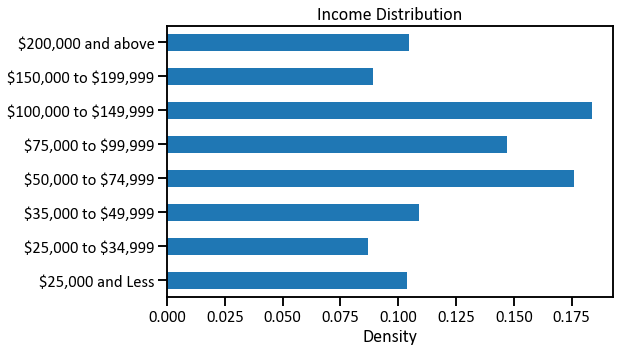

In [ ]:
sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df['INCOME'].value_counts(normalize=True).sort_index().plot(kind="barh", ax=ax)
ax.set_yticklabels(income_translation_dict.values())
ax.set_title("Income Distribution")
ax.set_xlabel("Density");

In [ ]:
income_depression_pivot = df.pivot_table(index="WEEK", columns="INCOME_text", values="SYMPTOMATIC")

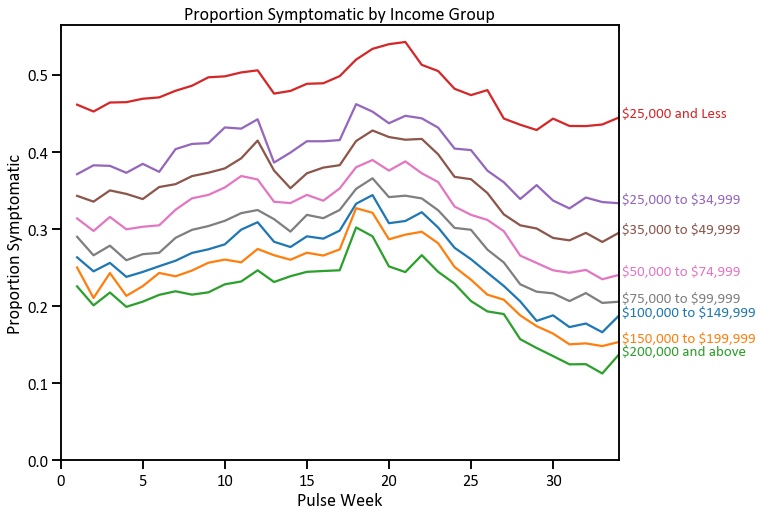

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
income_depression_pivot.plot(ax=ax, legend=False)
ax.set_xlim(0, 34)
ax.set_ylim(0)
for i in range(income_depression_pivot.shape[1]):
    plt.text(34.2, income_depression_pivot.iloc[-1, i], income_depression_pivot.columns[i], size=15, c=ax.get_lines()[i].get_c())
ax.set_ylabel("Proportion Symptomatic")
ax.set_xlabel("Pulse Week")
ax.set_title("Proportion Symptomatic by Income Group");

In [ ]:
income_translation_dict

{1: '\\$25,000 and Less',
 2: '\\$25,000 to \\$34,999',
 3: '\\$35,000 to \\$49,999',
 4: '\\$50,000 to \\$74,999',
 5: '\\$75,000 to \\$99,999',
 6: '\\$100,000 to \\$149,999',
 7: '\\$150,000 to \\$199,999',
 8: '\\$200,000 and above'}

In [ ]:
# Single, < 75k
single_household = (df['THHLD_NUMPER'] == 1)
not_married = (df['MS'] != 1)
married = (df['MS'] == 1)
income_under_75k = (df['INCOME'] < 5)
income_under_150k = (df['INCOME'] < 7)

# non_single_household = (df['THHLD_NUMPER'] > 1)

income_under_75k | (married & income_under_150k)

0         True
1         True
2        False
3         True
4         True
         ...  
64556    False
64557    False
64558    False
64560     True
64561    False
Length: 2245964, dtype: bool

In [ ]:
df['Eligible'] = income_under_75k | (married & income_under_150k)

In [ ]:
df.head()

,Unnamed: 0,SCRAM,WEEK,EST_ST,EST_MSA,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,EGENDER,AGENDER,...,HSE_TEMP,ENRGY_BILL,SUMMER_ED1,SUMMER_ED2,SUMMER_ED3,SUMMER_ED4,SYMPTOMATIC,TREAT,INCOME_text,Eligible
0,0,V010000001S10011099370111,1,47,NaN,1973.489532,1986,2,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,"\$50,000 to \$74,999",True
1,1,V010000001S10011900470112,1,1,NaN,1929.488419,1955,2,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,"\$25,000 to \$34,999",True
2,2,V010000001S18010744940111,1,26,NaN,1526.612380,1976,2,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,"\$200,000 and above",False
3,3,V010000001S37010301340112,1,1,NaN,2734.635354,1964,2,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,"\$25,000 and Less",True
4,4,V010000001S37010480340111,1,1,NaN,681.211425,1963,2,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,"\$50,000 to \$74,999",True


In [ ]:
df['Eligible'].value_counts(normalize=True)

True     0.711526
False    0.288474
Name: Eligible, dtype: float64

In [ ]:
df['MS'].value_counts()

1    1318828
5     421821
3     349667
2     115401
4      40247
Name: MS, dtype: int64

In [ ]:
df['THHLD_NUMPER'].value_counts()

2     865065
1     393247
3     381647
4     340360
5     154366
6      62598
7      22998
10     12426
8       9589
9       3668
Name: THHLD_NUMPER, dtype: int64

In [ ]:
df['THHLD_NUMKID'].value_counts()

0    1487961
1     332594
2     273768
3     101583
4      33529
5      16529
Name: THHLD_NUMKID, dtype: int64

Text(0.5, 0, 'Pulse Week')

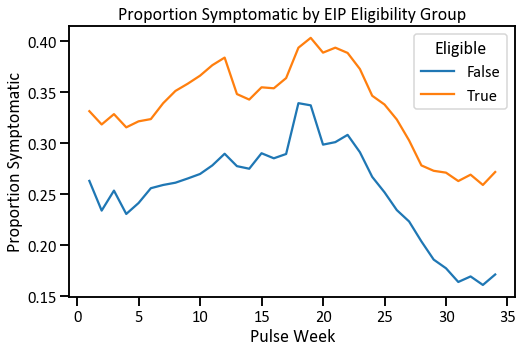

In [ ]:

df.pivot_table(index="WEEK", columns="Eligible", values="SYMPTOMATIC").plot(figsize=(8, 5))
plt.title("Proportion Symptomatic by EIP Eligibility Group")
plt.ylabel("Proportion Symptomatic")
plt.xlabel("Pulse Week")

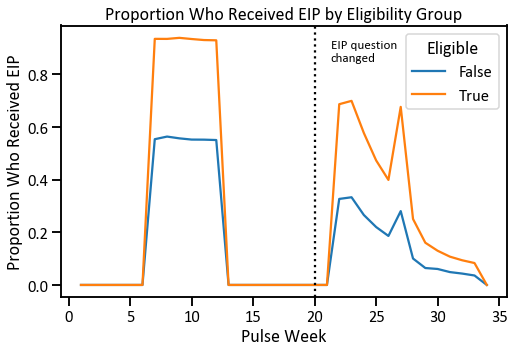

In [ ]:
df.pivot_table(index="WEEK", columns="Eligible", values="TREAT").plot(figsize=(8, 5))
plt.axvline(20, linestyle=":", c="black")
plt.text(21.3, 0.85, 'EIP question\nchanged', size=13)
plt.title("Proportion Who Received EIP by Eligibility Group")
plt.ylabel("Proportion Who Received EIP")
plt.xlabel("Pulse Week");

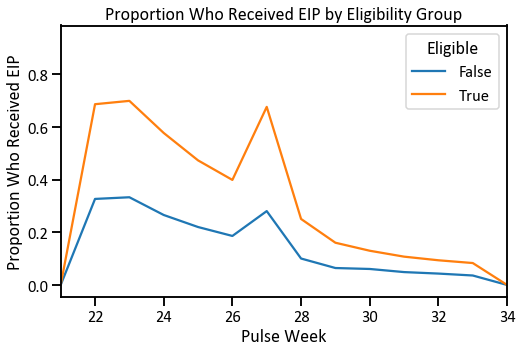

In [ ]:
df.pivot_table(index="WEEK", columns="Eligible", values="TREAT", aggfunc=np.mean).plot(figsize=(8, 5))
plt.xlim(21, 34)
plt.title("Proportion Who Received EIP by Eligibility Group")
plt.ylabel("Proportion Who Received EIP")
plt.xlabel("Pulse Week");

In [ ]:
df_phase3 = df.query("WEEK > 21")

<AxesSubplot:xlabel='WEEK'>

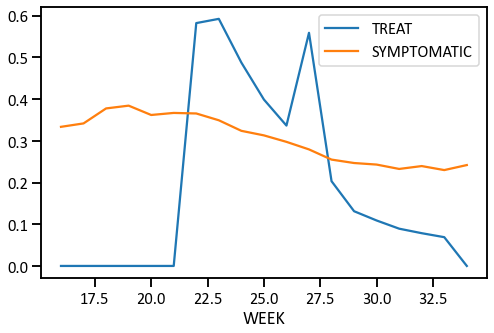

In [ ]:
df.groupby("WEEK")[['TREAT', 'SYMPTOMATIC']].mean().iloc[15:, :].plot(figsize=(8, 5))

In [ ]:
df_phase3["TREAT"].value_counts()

0    501398
1    206194
Name: TREAT, dtype: int64

In [ ]:
25058 / 537894

0.046585386711880034

In [ ]:
df_phase3.pivot_table(index="WEEK", columns="Eligible", values="TREAT", aggfunc=np.sum)

Eligible,False,True
WEEK,,
22,4818,24981
23,5966,30626
24,4465,24176
25,3802,19889
26,3193,16624
27,4806,27646
28,1569,8557
29,1112,6406
30,970,4821


<AxesSubplot:xlabel='WEEK'>

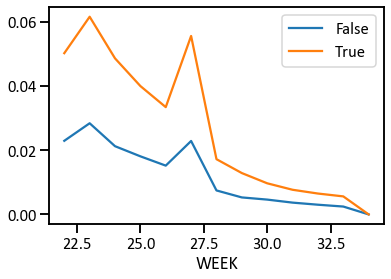

In [ ]:
(df_phase3.pivot_table(index="WEEK", columns="Eligible", values="TREAT", aggfunc=np.sum) / df_phase3["Eligible"].value_counts()).plot()


In [ ]:
pd.DataFrame(df_phase3["Eligible"].value_counts()).sort_index().T.values

array([[210146, 497446]], dtype=int64)

In [ ]:
df_phase3.pivot_table(index="Eligible", columns="WEEK", values=["SYMPTOMATIC"], aggfunc=np.mean).T

Eligible             False      True
            WEEK                    
SYMPTOMATIC 22    0.308312  0.388700
            23    0.291299  0.372905
            24    0.267122  0.346684
            25    0.251980  0.338102
            26    0.234527  0.323393
            27    0.223356  0.302857
            28    0.203821  0.278350
            29    0.185944  0.273061
            30    0.177456  0.271254
            31    0.164012  0.263014
            32    0.169440  0.269268
            33    0.161095  0.259185
            34    0.171359  0.271885

In [ ]:
table = (df_phase3.pivot_table(index="Eligible", columns="WEEK", values=["TREAT"], aggfunc=np.sum).T / pd.DataFrame(df_phase3["Eligible"].value_counts()).sort_index().T.values).cumsum()
melted_table = table.reset_index().melt(id_vars="WEEK")

In [156]:
df_phase3['WEEK'] = df_phase3['WEEK'].astype(str)
X = pd.get_dummies(df_phase3[['TREAT', 'WEEK', 'Eligible']], drop_first=True).astype(int)
y = df_phase3['SYMPTOMATIC']
X = sm.add_constant(X)
X

C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_15964\3726847954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_phase3['WEEK'] = df_phase3['WEEK'].astype(str)


,const,TREAT,Eligible,WEEK_23,WEEK_24,WEEK_25,WEEK_26,WEEK_27,WEEK_28,WEEK_29,WEEK_30,WEEK_31,WEEK_32,WEEK_33,WEEK_34
1,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64556,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
64557,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
64558,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
64560,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [174]:
df_phase3["WEEK"]

1        22
2        22
3        22
4        22
5        22
         ..
64556    34
64557    34
64558    34
64560    34
64561    34
Name: WEEK, Length: 707592, dtype: object

In [201]:
del df

In [219]:
test_model = sm.OLS.from_formula("SYMPTOMATIC ~ 1 + TREAT + Eligible + C(WEEK, Treatment(reference = '22'))", data=df_phase3).fit(cov_type='HC0')

In [220]:
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SYMPTOMATIC   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     995.0
Date:                Sun, 20 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:07:31   Log-Likelihood:            -4.3111e+05
No. Observations:              707592   AIC:                         8.623e+05
Df Residuals:                  707577   BIC:                         8.624e+05
Df Model:                          14                                         
Covariance Type:                  HC0                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.2905      0.002    124.453      0.000       0.286       0.295
Eligible[T.True]                             0.0829      0.001     72.944      0.000       0.081       0.085
C(WEEK, Treatment(reference='22'))[T.23]    -0.0164      0.003     -5.749      0.000      -0.022      -0.011
C(WEEK, Treatment(reference='22'))[T.24]    -0.0392      0.003    -13.662      0.000      -0.045      -0.034
C(WEEK, Treatment(reference='22'))[T.25]    -0.0472      0.003    -16.529      0.000      -0.053      -0.042
C(WEEK, Treatment(reference='22'))[T.26]    -0.0610      0.003    -21.385      0.000      -0.067      -0.055
C(WEEK, Treatment(reference='22'))[T.27]    -0.0849      0.003    -30.118      0.000      -0.090      -0.079
C(WEEK, Treatment(reference='22'))[T.28]    -0.0980      0.003    -33.503      0.000      -0.104      -0.092
C(WEEK, Treatment(reference='22'))[T.29]    -0.1053      0.003    -36.978      0.000      -0.111      -0.100
C(WEEK, Treatment(reference='22'))[T.30]    -0.1085      0.003    -37.542      0.000      -0.114      -0.103
C(WEEK, Treatment(reference='22'))[T.31]    -0.1178      0.003    -40.691      0.000      -0.124      -0.112
C(WEEK, Treatment(reference='22'))[T.32]    -0.1114      0.003    -37.917      0.000      -0.117      -0.106
C(WEEK, Treatment(reference='22'))[T.33]    -0.1207      0.003    -41.049      0.000      -0.126      -0.115
C(WEEK, Treatment(reference='22'))[T.34]    -0.1068      0.003    -36.222      0.000      -0.113      -0.101
TREAT                                        0.0275      0.001     19.608      0.000       0.025       0.030
==============================================================================
Omnibus:                   246880.157   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           136174.566
Skew:                           0.949   Prob(JB):                         0.00
Kurtosis:                       1.992   Cond. No.                         18.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [221]:
test = df_phase3[['TREAT', 'Eligible', 'WEEK', 'SYMPTOMATIC']].astype(int).set_index(['Eligible', 'WEEK']).sort_index()

In [222]:
PanelOLS.from_formula("SYMPTOMATIC ~ 1 + TREAT + EntityEffects + TimeEffects", data=test).fit().summary

Dep. Variable:,SYMPTOMATIC,R-squared:,0.0006
Estimator:,PanelOLS,R-squared (Between):,-0.0303
No. Observations:,707592,R-squared (Within):,0.0027
Date:,"Sun, Nov 20 2022",R-squared (Overall):,0.0037
Time:,18:07:39,Log-likelihood,-4.311e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,415.32
Entities:,2,P-value,0.0000
Avg Obs:,3.538e+05,Distribution:,"F(1,707577)"
Min Obs:,2.101e+05,,
Max Obs:,4.974e+05,F-statistic (robust):,415.32


In [105]:
pooled_panel_data = df_phase3.groupby(["Eligible", "WEEK"])[['SYMPTOMATIC', 'TREAT']].mean().reset_index()

In [106]:
pooled_panel_data['Eligible'] = pooled_panel_data['Eligible'].astype(int)
pooled_panel_data['WEEK'] = pooled_panel_data['WEEK'].astype(str)

In [131]:
pooled_panel_data

,Eligible,WEEK,SYMPTOMATIC,TREAT
0,0,22,0.308312,0.326401
1,0,23,0.291299,0.332738
2,0,24,0.267122,0.265458
3,0,25,0.251980,0.219781
4,0,26,0.234527,0.185910
5,0,27,0.223356,0.280201
6,0,28,0.203821,0.100249
7,0,29,0.185944,0.064214
8,0,30,0.177456,0.060610
9,0,31,0.164012,0.048793


In [132]:
X = pd.get_dummies(pooled_panel_data[['Eligible', 'WEEK', 'TREAT']], drop_first=True)
X = sm.add_constant(X)

In [142]:
ols_model = sm.OLS(pooled_panel_data['TREAT'].values, X, hasconst=True)

In [143]:
ols_model = naive_ols_model.fit(cov_type='HC0')

In [144]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SYMPTOMATIC   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 20 Nov 2022   Prob (F-statistic):                nan
Time:                        15:02:03   Log-Likelihood:            -4.3355e+05
No. Observations:              707592   AIC:                         8.671e+05
Df Residuals:                  707578   BIC:                         8.673e+05
Df Model:                          13                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TREAT          0.0476      0.001     34.849      0.000       0.045       0.050
WEEK_22        0.3378      0.002    149.152      0.000       0.333       0.342
WEEK_23        0.3210      0.002    154.986      0.000       0.317       0.325
WEEK_24        0.3007      0.002    147.922      0.000       0.297       0.305
WEEK_25        0.2940      0.002    149.249      0.000       0.290       0.298
WEEK_26        0.2814      0.002    145.867      0.000       0.278       0.285
WEEK_27        0.2528      0.002    126.437      0.000       0.249       0.257
WEEK_28        0.2453      0.002    124.640      0.000       0.241       0.249
WEEK_29        0.2405      0.002    133.119      0.000       0.237       0.244
WEEK_30        0.2378      0.002    127.565      0.000       0.234       0.241
WEEK_31        0.2283      0.002    122.407      0.000       0.225       0.232
WEEK_32        0.2357      0.002    122.571      0.000       0.232       0.239
WEEK_33        0.2265      0.002    117.916      0.000       0.223       0.230
WEEK_34        0.2419      0.002    127.108      0.000       0.238       0.246
==============================================================================
Omnibus:                   255715.962   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           139450.157
Skew:                           0.962   Prob(JB):                         0.00
Kurtosis:                       1.985   Cond. No.                         2.92
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [113]:
PanelOLS(pooled_panel_data['TREAT'].values, X)

linearmodels.panel.model.PanelOLS